In [8]:
from scipy.stats import zscore
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import warnings
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
from sklearn.impute import KNNImputer, SimpleImputer

In [9]:
df = pd.read_csv("SP 500 ESG Risk Ratings.csv")

In [11]:
df.describe()#.T.style.background_gradient()

,Total ESG Risk score,Environment Risk Score,Governance Risk Score,Social Risk Score,Controversy Score
count,430.000000,430.000000,430.000000,430.000000,403.000000
mean,21.533721,5.739767,6.725116,9.070465,2.007444
std,6.889176,5.092421,2.208085,3.657924,0.793283
min,7.100000,0.000000,3.000000,0.800000,1.000000
25%,16.400000,1.800000,5.300000,6.700000,1.000000
50%,21.050000,4.050000,6.100000,8.900000,2.000000
75%,26.000000,8.950000,7.675000,11.200000,2.000000
max,41.700000,25.000000,19.400000,22.500000,5.000000


In [12]:
df.describe(include=['object'])

,Symbol,Name,Address,Sector,Industry,Full Time Employees,Description,Controversy Level,ESG Risk Percentile,ESG Risk Level
count,503,503,502,502,502,498,502,430,430,430
unique,503,503,498,11,116,394,499,6,89,5
top,ENPH,"Enphase Energy, Inc.","1211 Avenue of the Americas\nNew York, NY 1003...",Technology,Utilities - Regulated Electric,"18,000",Alphabet Inc. offers various products and plat...,Moderate Controversy Level,16th percentile,Low
freq,1,1,4,76,23,10,2,199,12,187


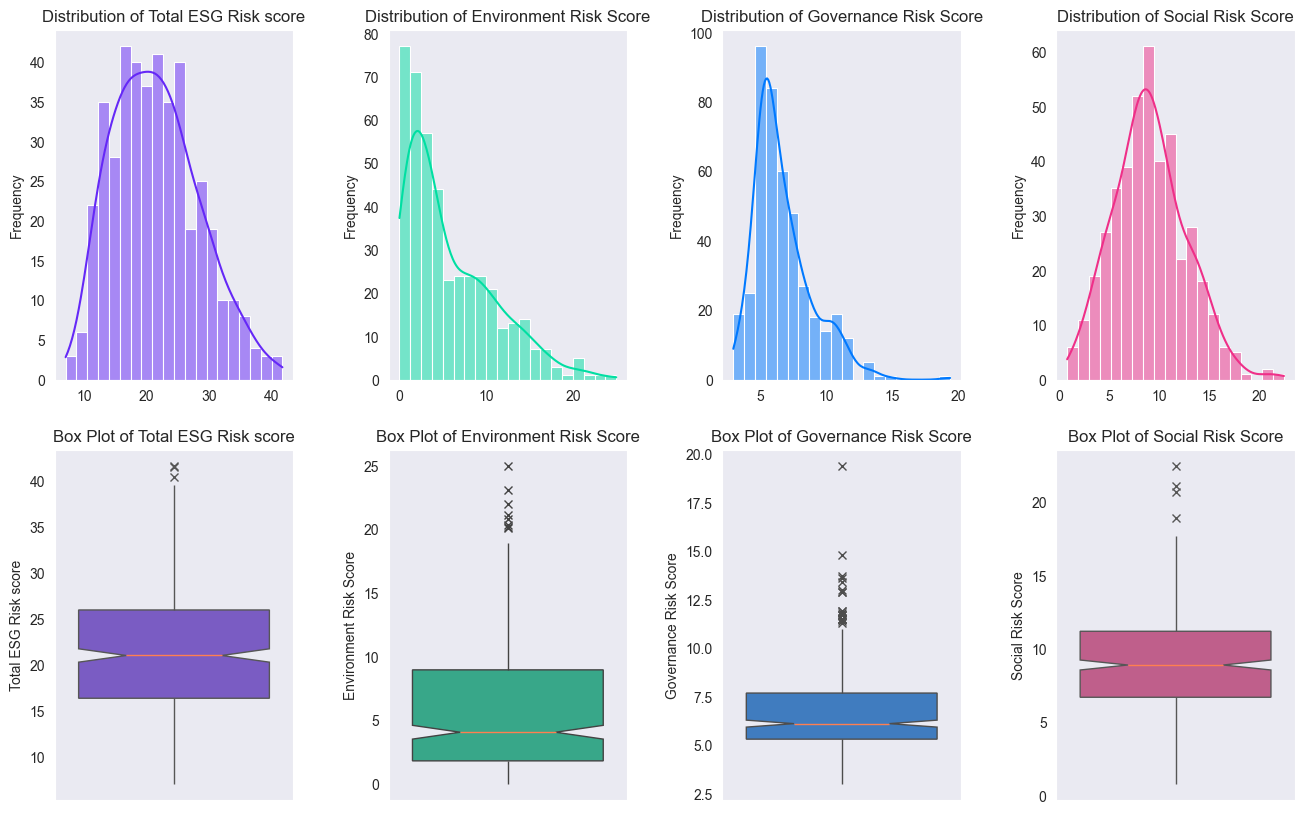

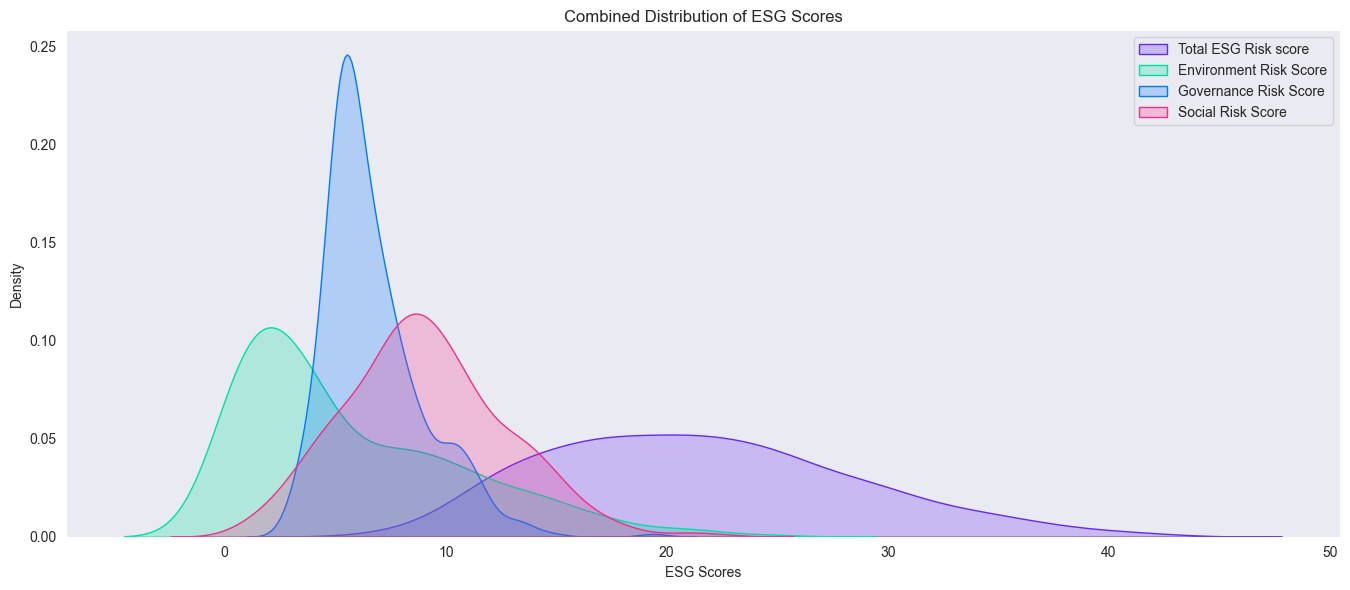

Summary Statistics for ESG Scores:
+-------+----------------------+------------------------+-----------------------+--------------------+
|       | Total ESG Risk score | Environment Risk Score | Governance Risk Score | Social Risk Score  |
+-------+----------------------+------------------------+-----------------------+--------------------+
| count |        430.0         |         430.0          |         430.0         |       430.0        |
| mean  |  21.53372093023256   |   5.739767441860465    |   6.725116279069767   |  9.07046511627907  |
|  std  |  6.889176174272724   |   5.092420890749431    |   2.208084712671996   | 3.6579239615621457 |
|  min  |         7.1          |          0.0           |          3.0          |        0.8         |
|  25%  |         16.4         |          1.8           |          5.3          |        6.7         |
|  50%  |        21.05         |          4.05          |          6.1          |        8.9         |
|  75%  |         26.0         |      

In [13]:
from tabulate import tabulate 

esg_scores = df[['Total ESG Risk score', 'Environment Risk Score', 'Governance Risk Score', 'Social Risk Score']]

# Set style
sns.set_style("dark")

# Define a custom color palette
colors = ["#6528F7", "#00DFA2", "#0079FF", "#EF2F88"]

# Create subplots for histograms and distribution plots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 10))
plt.subplots_adjust(wspace=0.4)

# Iterate through each ESG score column
for i, col in enumerate(esg_scores.columns):
    # Plot histogram
    sns.histplot(
        esg_scores[col], 
        bins=20, 
        kde=True, 
        ax=axes[0, i], 
        color=colors[i]
    )
    axes[0, i].set_xlabel('')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_title(f'Distribution of {col}')

    # Plot box plot with the same color
    sns.boxplot(
        y=esg_scores[col], 
        ax=axes[1, i], 
        color=colors[i],
        saturation=0.5,
        notch=True, 
        showcaps=False,
        flierprops={"marker": "x"},
        medianprops={"color":"coral"}
    )
    axes[1, i].set_ylabel(col)
    axes[1, i].set_xlabel('')
    axes[1, i].set_title(f'Box Plot of {col}')


#  Create a single KDE plot for all ESG scores
plt.figure(figsize=(13.6, 6))

# Iterate through each ESG score column and plot its KDE
for i, col in enumerate(esg_scores.columns):
    sns.kdeplot(
        esg_scores[col],
        color=colors[i], 
        label=col, 
        fill=True
    )
    
# Add labels and a title
plt.xlabel('ESG Scores')
plt.ylabel('Density')
plt.title('Combined Distribution of ESG Scores')


# Add a legend
plt.legend()

plt.tight_layout()
plt.show()


# Identify and display outliers
outliers = {}

for col in esg_scores.columns:
    Q1 = esg_scores[col].quantile(0.25)
    Q3 = esg_scores[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    col_outliers = esg_scores[(esg_scores[col] < lower_bound) | (esg_scores[col] > upper_bound)]
    outliers[col] = col_outliers

# Display summary statistics as a nice table
summary_stats = esg_scores.describe()
print("Summary Statistics for ESG Scores:")
print(tabulate(summary_stats, headers='keys', tablefmt='pretty'))

# Display outliers as nice tables
for col, outlier_df in outliers.items():
    print(f"Outliers in {col}:")
    print(tabulate(outlier_df, headers='keys', tablefmt='pretty'))

In [14]:
# Create a copy of the original dataset
data_no_outliers = df.copy()

# Identify and remove outliers
for col in esg_scores.columns:
    Q1 = esg_scores[col].quantile(0.25)
    Q3 = esg_scores[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers from the copy of the dataset
    data_no_outliers = data_no_outliers[(data_no_outliers[col] >= lower_bound) & (data_no_outliers[col] <= upper_bound)]

# Reset the index of the new DataFrame
data_no_outliers.reset_index(drop=True, inplace=True)

# Display the shape of the new dataset without outliers
print(f"Shape of the dataset without outliers: {data_no_outliers.shape}")

Shape of the dataset without outliers: (397, 15)


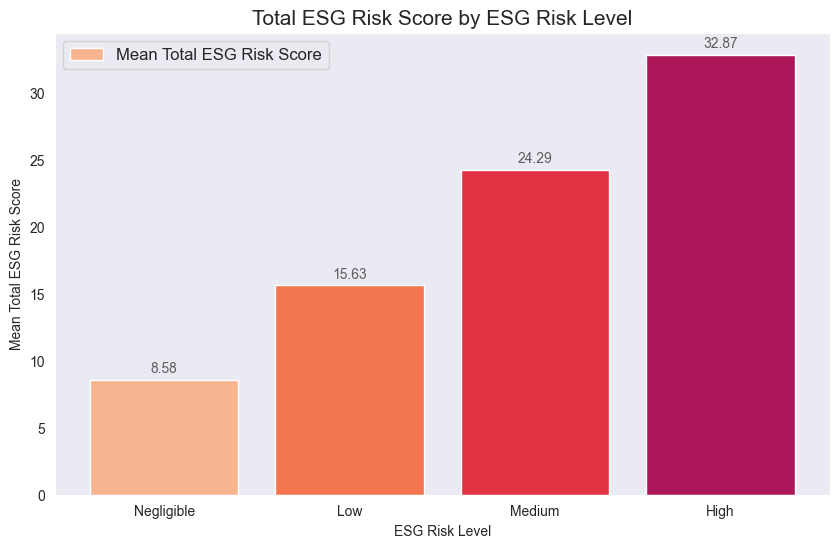

In [15]:
# Group by 'ESG Risk Level' and calculate the mean 'Total ESG Risk Score' for each level
grouped_data = data_no_outliers.groupby('ESG Risk Level')['Total ESG Risk score'].mean().reset_index()

# Define the ESG risk levels
risk_levels = ['Negligible', 'Low', 'Medium', 'High']

sns.set_style("dark")

# Create a figure and axis
plt.figure(figsize=(10, 6))
ax = plt.subplot()

# Sort the grouped data by ESG Risk Level in the desired order
grouped_data = grouped_data.loc[grouped_data['ESG Risk Level'].isin(risk_levels)]
grouped_data = grouped_data.set_index('ESG Risk Level').loc[risk_levels].reset_index()

# Use a Seaborn color palette
palette = sns.color_palette("rocket_r")  # Convert to a list of colors

# Create a bar chart for 'Total ESG Risk Score' for each risk level with the Seaborn palette
bars = ax.bar(grouped_data['ESG Risk Level'], grouped_data['Total ESG Risk score'], color=palette)

# Add labels and title
plt.xlabel('ESG Risk Level')
plt.ylabel('Mean Total ESG Risk Score')
plt.title('Total ESG Risk Score by ESG Risk Level', fontsize=15)

# Add a legend for color reference
ax.legend([f'Mean Total ESG Risk Score'], fontsize=12, loc='upper left')

# Add data labels above the bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10,
                color='black', alpha=0.6)

# Show the plot
plt.show()


In [16]:
# Count the number of Unique Sectors
sectors_count = df['Sector'].nunique()

print("Number of Unique Sectors:", sectors_count)

# Count the number of Unique Industries
industries_count = df['Industry'].nunique()

print("Number of Unique Industries:", industries_count)

Number of Unique Sectors: 11
Number of Unique Industries: 116


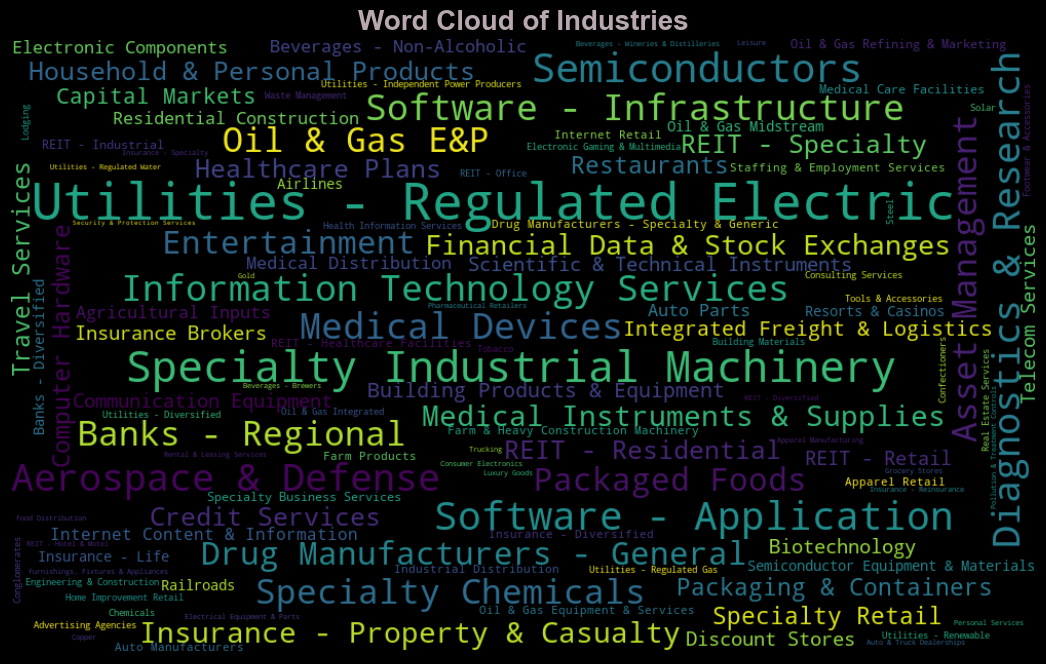

In [17]:
# Get the unique industries and their frequency counts
industry_counts = df['Industry'].value_counts()

# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=600, background_color='black', colormap='viridis').generate_from_frequencies(industry_counts)

# Display the word cloud
plt.figure(figsize=(16, 8), facecolor='black')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Industries", color="#b8a9b1", fontsize=20, fontweight="bold")
plt.show()

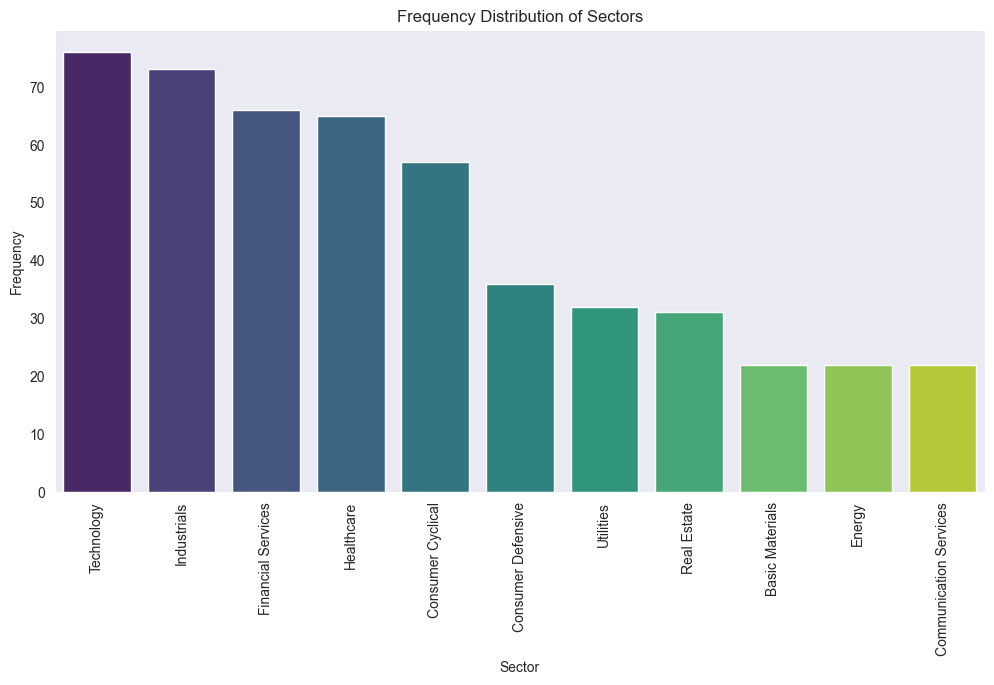

In [19]:
# Frequency count for Sector
sector_counts = df['Sector'].value_counts()

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values, hue=sector_counts.index, palette='viridis', legend=False)
plt.title('Frequency Distribution of Sectors')
plt.xlabel('Sector')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

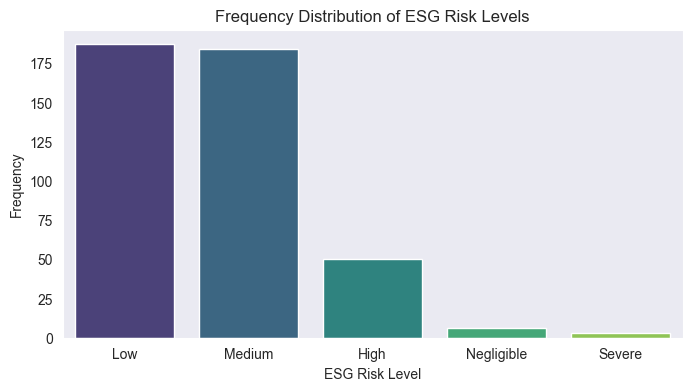

In [20]:
# Frequency count for ESG Risk Level
esg_risk_level_counts = df['ESG Risk Level'].value_counts()

# Plotting the distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=esg_risk_level_counts.index, y=esg_risk_level_counts.values, hue=esg_risk_level_counts.index, palette='viridis', legend=False)
plt.title('Frequency Distribution of ESG Risk Levels')
plt.xlabel('ESG Risk Level')
plt.ylabel('Frequency')
plt.show()

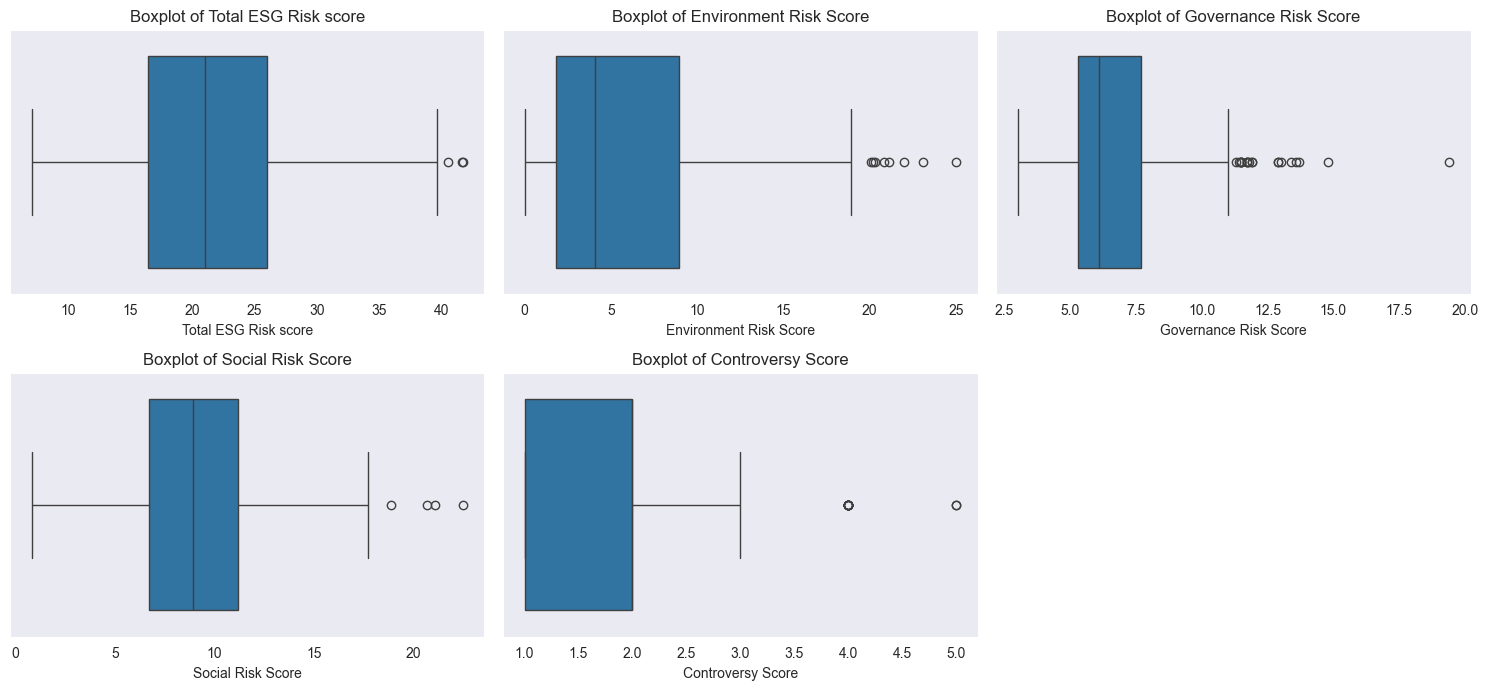

In [21]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
num_cols = len(numerical_columns)
num_subplots = min(num_cols, 9)  # Maximum 9 subplots

for i, column in enumerate(numerical_columns[:num_subplots], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [22]:
###MISSING VALUE
# KNN 

In [23]:
# Check for null values
null_values = df.isna().sum()
columns_with_null = null_values[null_values > 0]

# Display columns with null values
print("Columns with null values:")
print(columns_with_null)

Columns with null values:
Address                     1
Sector                      1
Industry                    1
Full Time Employees         5
Description                 1
Total ESG Risk score       73
Environment Risk Score     73
Governance Risk Score      73
Social Risk Score          73
Controversy Level          73
Controversy Score         100
ESG Risk Percentile        73
ESG Risk Level             73
dtype: int64


In [24]:
# Impute missing values
for column, count in columns_with_null.items():
    if df[column].dtype == 'object':  # Handling categorical columns
        # Fill with mode (most frequent value)
        mode_value = df[column].mode()[0]
        df[column] = df[column].fillna(mode_value)
    else:  # Handling numerical columns
        # Fill with mean
        mean_value = df[column].mean()
        df[column] = df[column].fillna(mean_value)

# Verify null values after imputation
print("\nNull values after imputation:")
print(df.isna().sum())


Null values after imputation:
Symbol                    0
Name                      0
Address                   0
Sector                    0
Industry                  0
Full Time Employees       0
Description               0
Total ESG Risk score      0
Environment Risk Score    0
Governance Risk Score     0
Social Risk Score         0
Controversy Level         0
Controversy Score         0
ESG Risk Percentile       0
ESG Risk Level            0
dtype: int64


In [25]:
# using the zscore

def handle_outliers_zscore(data, column, threshold=3):
    z_scores = zscore(data[column])
    outliers = (z_scores > threshold) | (z_scores < -threshold)
    
    # Replace outliers with the median
    data.loc[outliers, column] = data[column].median()
    return data


numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
for column in numerical_columns:
    df = handle_outliers_zscore(df, column)

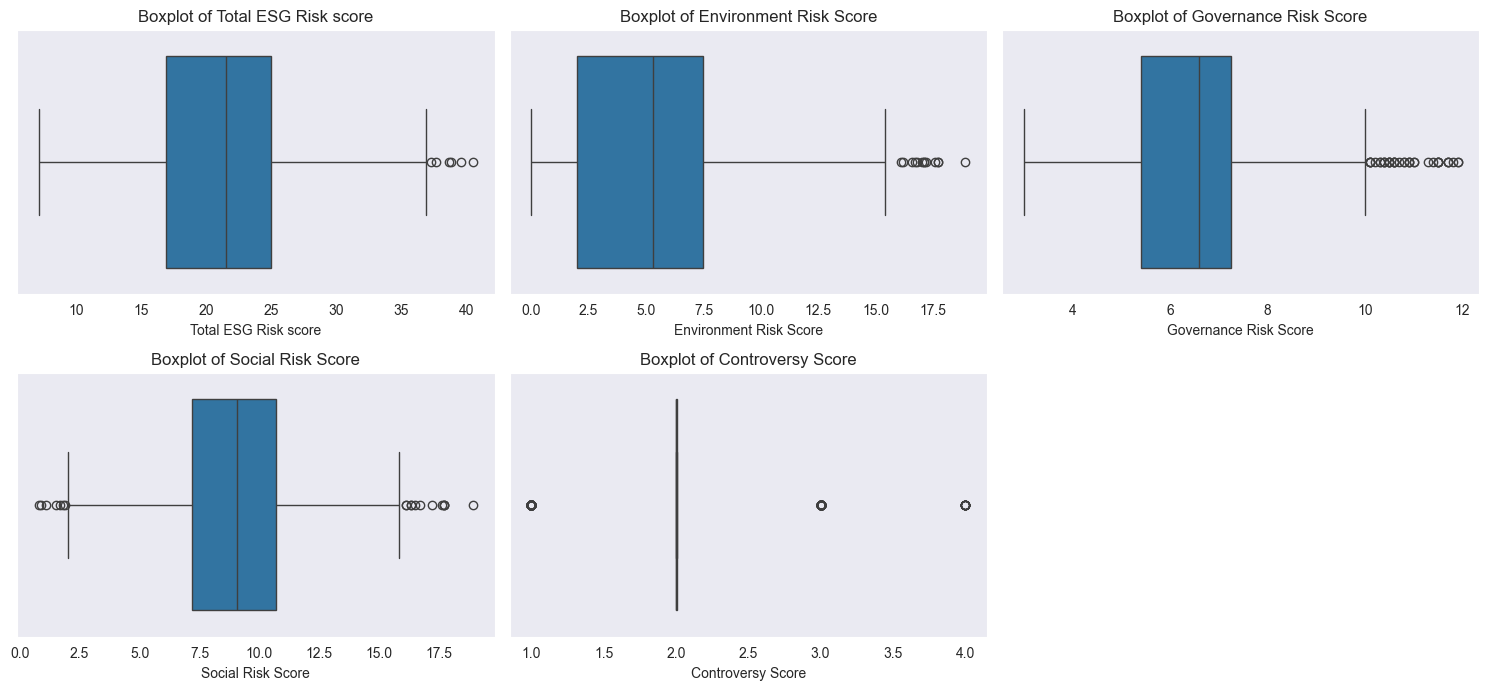

In [26]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns[:num_subplots], 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show();